In [91]:
import numpy as np
import tensorflow as tf
import pickle
import pickle
import pandas as pd
from utils import *
from random import randint

from sklearn.manifold import TSNE

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from seq2seq import *
from recurrentshop import *

from keras.layers.wrappers import TimeDistributed
from keras import regularizers
from keras import backend as K

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
time_percentage = 0.9
explained_variance = 0.90
process = False
filename = 'data.pickle'
delete_other_idle = False


if (process):
    df = pd.read_csv('data/rescuetime_data_category_2017-07-21.csv')
    data = Clean_DF(df)
    data.clean_data(time_percentage=time_percentage)
    data.clean_df = data.clean_df.reset_index()
    data.get_pca(explained_variance=explained_variance)
    data.get_day_time()

    with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(data, f)
else:
    with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
        data = pickle.load(f)
    
dataset = data.activity_vector
popular_apps = data.popular_apps


if (delete_other_idle):
# Remove IDLE and OTHER time
    dataset = np.delete(dataset, [dataset.shape[1]-1,dataset.shape[1]-2], axis=1)
    del popular_apps[-1]
    del popular_apps[-1]

time_spent = dataset.sum(axis=0)/dataset.sum()*100


print("Dataset size:", dataset.shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(popular_apps), '\n')
print("Cleaned dataset columns:",'\n', data.clean_df.columns.values, '\n')

graphdata = [go.Bar(
            x=popular_apps,
            y=time_spent
    )]

py.iplot(graphdata, filename='basic-bar')

Dataset size: (18296, 15) 

Number of apps that consume 90.0 % of all users time:  15 

Cleaned dataset columns: 
 ['Date' 'Time Spent (seconds)' 'Category' 'Activity Vector' 'Day' 'Time'] 



In [41]:
INPUT_DIM = len(popular_apps)
INPUT_LENGTH = 8
TRAIN_SPLIT = 0.8

In [42]:
xN, yN, X_train, X_test, Y_train,Y_test = split2sequences(dataset,INPUT_LENGTH,INPUT_LENGTH, TRAIN_SPLIT)

print("Dataset shape: ", dataset.shape)
print("xN shape: ", xN.shape)
print("yN shape: ", yN.shape, "\n",)
print("==================================  ", "\n" )
print("Train/Valid split = ", TRAIN_SPLIT, np.round(1-TRAIN_SPLIT,2), "\n")
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape, "\n")
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

Splitting text into sequences... 

Dataset shape:  (18296, 15)
xN shape:  (18287, 8, 15)
yN shape:  (18287, 8, 15) 


Train/Valid split =  0.8 0.2 

X_train shape:  (14629, 8, 15)
Y_train shape:  (14629, 8, 15) 

X_test shape:  (3658, 8, 15)
Y_test shape:  (3658, 8, 15)


# LSTM prediction

    samples = total number of observations
    input_length = number of timesteps in the input sequence
    input_dim = size of each observation

xN = (samples, input_length, input_dim)
yN = xN shifted by 1

In [106]:
def build_model(N_HIDDEN, N_HIDDEN2=0, N_DENSE=0, Dp=0.0, final_activation='sigmoid', type_cell='LSTM'):
    
    inputs = Input(shape=(INPUT_LENGTH, INPUT_DIM), name='Inputs')
    
    if (type_cell=='LSTM'):
        encoded = LSTM(N_HIDDEN, return_sequences=True, name='LSTM1')(inputs)
    else:
        encoded = GRU(N_HIDDEN, return_sequences=True, name='GRU1')(inputs)
        
        
    if (N_HIDDEN2 > 0):
        if (type_cell=='LSTM'):
            encoded = LSTM(N_HIDDEN2, return_sequences=True, name='LSTM2')(encoded)
        else:
            encoded = GRU(N_HIDDEN2, return_sequences=True, name='GRU2')(encoded)

    if (N_DENSE > 0):
        dense1 = TimeDistributed(Dense(N_DENSE, activation='relu'), name='TimeDistributed_Relu')(encoded)
        if(Dp>0):
            dense1 = TimeDistributed(Dropout(Dp))(dense1)
            
        dense2 = TimeDistributed(Dense(INPUT_DIM, activation=final_activation), name='Output')(dense1)
    else:
        dense2 = TimeDistributed(Dense(INPUT_DIM, activation=final_activation), name='Output')(encoded)

    encoder = Model(inputs, encoded)
    model = Model(inputs, dense2)
    
    return model, encoder

In [121]:
N_HIDDEN = 32
N_HIDDEN2 = 0
N_DENSE = 128

BATCH_SIZE = 64
EPOCHS = 20

model, encoder = build_model(N_HIDDEN, N_HIDDEN2, N_DENSE)

model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 8, 15)             0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 8, 32)             6144      
_________________________________________________________________
TimeDistributed_Relu (TimeDi (None, 8, 128)            4224      
_________________________________________________________________
Output (TimeDistributed)     (None, 8, 15)             1935      
Total params: 12,303
Trainable params: 12,303
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
# model.optimizer.lr.assign(0.001)
rnn_model = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

/home/asturkmani/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



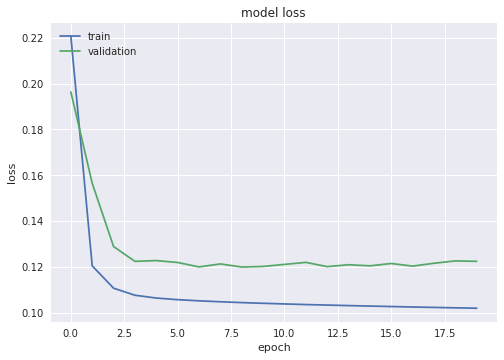

In [123]:
plt.plot(rnn_model.history['loss'])
plt.plot(rnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [124]:
y_pred = model.predict(X_test)
for i in range(0,Y_test.shape[0],randint(0, 100)):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i][7]/np.sum(y_pred[i][7]) * 300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i][7]/np.sum(Y_test[i][7])*300), "\n")

=== Prediction === 

[ 111.    2.    0.   11.    5.    2.  150.    2.    3.    4.    3.    0.
    0.    1.    7.] 

=== True value === 

[ 157.    0.    0.   16.    0.    0.  128.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[ 103.    3.    1.    8.   21.    3.  108.    6.    3.    6.    5.    1.
    7.    5.   20.] 

=== True value === 

[  22.    0.    0.    0.    0.    0.  276.    0.    0.    0.    0.    0.
    0.    0.    1.] 

=== Prediction === 

[ 145.    4.    0.   42.    8.   17.   14.    9.    5.    5.   10.    0.
    1.    4.   34.] 

=== True value === 

[ 265.    0.    0.    0.    0.    0.    0.    0.   18.    0.    0.    0.
    0.    0.   18.] 

=== Prediction === 

[ 97.   5.   0.  77.   1.  13.  12.  55.  10.   3.  12.   0.   2.   6.   8.] 

=== True value === 

[   1.    0.   91.    0.    8.    9.    7.   14.    5.    0.  159.    0.
    3.    0.    2.] 

=== Prediction === 

[  13.    1.  124.    4.    7.    3.    3.    3.    7.    4.    1. 

    0.    0.    0.] 

=== Prediction === 

[   9.   13.    7.    1.   16.  196.    2.    7.    7.    5.    1.   15.
    1.    1.   19.] 

=== True value === 

[   0.    0.    0.    0.    0.  262.    0.   29.    4.    0.    0.    0.
    0.    0.    5.] 

=== Prediction === 

[ 101.    1.    9.   41.    1.   48.    1.   33.   13.    5.    5.    5.
    5.    3.   29.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.  279.    0.    0.    0.
    0.    0.   21.] 

=== Prediction === 

[ 111.    9.    1.   44.    3.   16.   15.   25.   18.    8.    9.    2.
    2.    7.   31.] 

=== True value === 

[ 118.    0.    6.    0.    0.    0.  151.    8.    0.    0.    0.    0.
    0.    0.   17.] 

=== Prediction === 

[ 125.   15.   24.   20.    4.   10.    8.   16.   15.    8.    3.   11.
    5.    2.   35.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.  100.    0.    0.    0.
    0.    0.  200.] 

=== Prediction === 

[  28.    2.    0.  228.    0

    3.    1.    9.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.   32.  219.    0.   46.    3.    0.
    0.    0.    0.] 

=== Prediction === 

[  10.    2.  151.   11.    8.    1.   27.    6.   24.   16.   10.    7.
    4.    0.   21.] 

=== True value === 

[   0.    0.  235.    0.    2.    4.    0.    1.   15.   40.    3.    0.
    0.    0.    0.] 

=== Prediction === 

[  12.   10.  154.    6.    9.   11.   31.    4.   15.    8.    2.   17.
    1.    0.   19.] 

=== True value === 

[   0.    0.  280.    0.    0.    0.    0.    0.    0.    0.    0.   20.
    0.    0.    0.] 

=== Prediction === 

[   8.    5.  177.    4.    7.    7.   32.    4.   13.    9.    2.    4.
    1.    0.   27.] 

=== True value === 

[   0.    0.  292.    0.    0.    0.    0.    0.    0.    0.    0.    8.
    0.    0.    0.] 

=== Prediction === 

[  26.    2.    6.  133.    1.   17.    8.   65.   14.    7.    3.    3.
    3.    1.   11.] 

=== True value === 

[   0.    0.    0.  294.    0

    0.    0.    2.] 

=== Prediction === 

[  53.    0.    5.   12.    3.    6.    1.   18.   14.   12.    3.    9.
  143.    1.   20.] 

=== True value === 

[  54.    0.    0.    0.    0.   10.    0.  226.    3.    0.    0.    5.
    0.    0.    3.] 

=== Prediction === 

[  13.  274.    0.    3.    1.    1.    1.    1.    2.    2.    0.    0.
    0.    0.    3.] 

=== True value === 

[   0.  300.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  73.    2.   10.    4.    2.    1.    2.   18.    3.    4.    3.    3.
  118.    7.   50.] 

=== True value === 

[  14.    0.    0.    0.    0.    6.    0.    0.   18.    0.    0.   40.
  215.    0.    6.] 

=== Prediction === 

[  30.    0.    4.    9.    1.    2.    0.   17.    5.    4.    6.    1.
  201.    1.   18.] 

=== True value === 

[   0.    0.    4.    0.    0.    5.    0.   56.    0.    0.    0.    0.
  223.    0.   13.] 

=== Prediction === 

[ 44.   2.  78.   7.   1.   2

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.  175.  108.    0.    0.
    0.    0.   17.] 

=== Prediction === 

[  97.    3.    0.   33.    1.   10.   10.  108.    5.    4.    7.    1.
    2.    6.   13.] 

=== True value === 

[   0.    0.    0.    0.    0.   12.    0.   57.    0.  206.    0.    0.
    0.    0.   25.] 

=== Prediction === 

[  31.    1.  189.   14.    2.    0.    3.    6.   19.    3.    3.    4.
    9.    0.   15.] 

=== True value === 

[   0.    0.  283.    0.    0.    0.    0.    0.   17.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  22.    2.  174.    9.    1.    5.   19.    5.    8.   15.    1.    1.
    2.    0.   35.] 

=== True value === 

[   0.    0.    0.    0.    0.   12.   95.    0.   12.    3.    0.  174.
    0.    0.    4.] 

=== Prediction === 

[  13.   23.  162.    7.    5.    6.   24.    4.    8.    4.    1.   29.
    1.    0.   12.] 

=== True value === 

[   0.    0.  300.    0.    0.    0.    0.    0.   

    0.    0.    0.] 

=== Prediction === 

[   7.   63.  118.   11.   14.    4.   10.    5.    6.    1.    1.   48.
    3.    0.    8.] 

=== True value === 

[  11.    0.  245.    0.    0.    0.    0.    0.    0.    0.    0.   44.
    0.    0.    0.] 

=== Prediction === 

[  13.   18.  170.    5.    8.    8.   30.    5.    7.    4.    1.   15.
    1.    0.   16.] 

=== True value === 

[   0.    0.  300.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  13.    6.  162.    3.    8.   17.   30.    5.    9.   11.    2.    3.
    1.    0.   31.] 

=== True value === 

[   0.    0.  300.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  13.    7.  155.    4.    6.   16.   35.    5.    8.   15.    2.    3.
    1.    0.   31.] 

=== True value === 

[   0.    0.  300.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[ 19.   5.  93.   4.   9.  10

    1.   11.  113.] 

=== True value === 

[   0.    0.   45.   24.    0.    2.    0.  175.    3.   13.   22.    0.
    0.    0.   15.] 

=== Prediction === 

[  28.    3.  186.    9.    3.    2.   12.    5.   12.    8.    2.    8.
    5.    0.   19.] 

=== True value === 

[   0.    0.  207.    0.    0.    0.    0.    0.    4.    0.    0.    0.
   78.    0.   11.] 

=== Prediction === 

[  15.    7.  168.    4.    7.   13.   28.    5.    9.   10.    1.    5.
    1.    0.   28.] 

=== True value === 

[   0.    0.  300.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   9.    5.  155.    3.    9.   15.   42.    5.   10.   13.    2.    3.
    1.    0.   29.] 

=== True value === 

[   0.    0.  213.    0.    0.   11.   10.    0.   14.    0.    0.   52.
    0.    0.    0.] 

=== Prediction === 

[  13.    6.  122.    5.    8.   11.   75.    5.    8.   18.    1.    4.
    1.    0.   23.] 

=== True value === 

[   0.    0.  103.    0.    0

In [129]:
N_HIDDEN = 32
N_HIDDEN2 = 32
N_DENSE = 32

BATCH_SIZE = 32
EPOCHS = 20

model, encoder = build_model(N_HIDDEN, N_HIDDEN2, N_DENSE, type_cell='GRU')

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 8, 15)             0         
_________________________________________________________________
GRU1 (GRU)                   (None, 8, 32)             4608      
_________________________________________________________________
GRU2 (GRU)                   (None, 8, 32)             6240      
_________________________________________________________________
TimeDistributed_Relu (TimeDi (None, 8, 32)             1056      
_________________________________________________________________
Output (TimeDistributed)     (None, 8, 15)             495       
Total params: 12,399
Trainable params: 12,399
Non-trainable params: 0
_________________________________________________________________
None


In [130]:
# model.optimizer.lr.assign(0.001)
rnn_model = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

/home/asturkmani/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



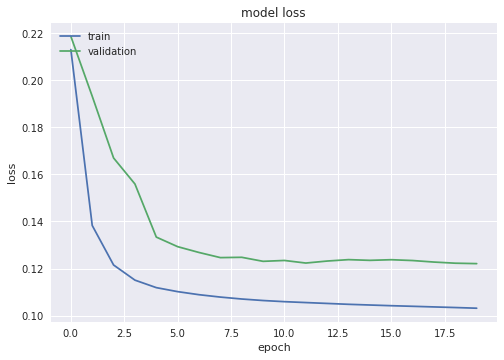

In [131]:
plt.plot(rnn_model.history['loss'])
plt.plot(rnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [132]:
y_pred = model.predict(X_test)
for i in range(0,Y_test.shape[0],randint(0, 100)):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i][7]/np.sum(y_pred[i][7]) * 300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i][7]/np.sum(Y_test[i][7])*300), "\n")

=== Prediction === 

[  83.    7.    1.   10.   11.    3.  151.    6.    4.    7.    6.    1.
    1.    0.    9.] 

=== True value === 

[ 157.    0.    0.   16.    0.    0.  128.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[ 144.    5.    1.   37.   10.   19.   11.   13.   13.    3.    9.    1.
    2.    2.   29.] 

=== True value === 

[ 265.    0.    0.    0.    0.    0.    0.    0.   18.    0.    0.    0.
    0.    0.   18.] 

=== Prediction === 

[  17.    2.  150.   10.   15.    0.    3.    3.    5.    3.    1.    1.
   13.    0.   77.] 

=== True value === 

[ 132.    0.    0.    0.   91.    0.    0.    0.    0.    0.    0.    0.
    0.    0.   76.] 

=== Prediction === 

[   8.   20.  196.   13.    2.    0.   15.    3.   11.    6.    3.   10.
    4.    0.   10.] 

=== True value === 

[   0.    0.  278.    0.    0.    0.    0.    0.   22.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   7.   10.  196.   14.    2.    1.   17.    5.   

=== Prediction === 

[ 119.   12.    1.   51.    9.   21.    7.   21.   15.    4.    4.    1.
    1.    4.   31.] 

=== True value === 

[ 300.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  23.  136.    4.   20.   12.   15.    3.    9.    8.   13.    3.    1.
    2.    1.   49.] 

=== True value === 

[   0.  258.    0.    0.    0.    0.    0.    0.   39.    0.    0.    0.
    0.    0.    3.] 

=== Prediction === 

[ 215.    4.    0.   33.    3.    4.    3.   11.    9.    2.    4.    0.
    1.    1.    9.] 

=== True value === 

[ 273.    0.    0.    0.    0.    0.    0.    0.    2.    0.    0.    0.
    0.    0.   25.] 

=== Prediction === 

[ 178.    1.    0.   13.    0.    4.    0.    5.    5.    4.    5.    0.
    0.   74.   10.] 

=== True value === 

[ 206.    0.    0.    5.    0.    0.    0.   50.   35.    0.    0.    0.
    0.    0.    5.] 

=== Prediction === 

[ 40.   4.   2.  54.  15.  29.  13.  26.  61.   9. 

=== Prediction === 

[ 74.   8.   1.  46.   4.  21.  13.  46.  21.   7.   8.   1.   3.   5.  44.] 

=== True value === 

[ 300.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  21.    4.    1.   37.    2.    5.    5.   13.    5.    5.  172.    0.
    6.    1.   24.] 

=== True value === 

[   0.    0.    0.    0.    0.    6.    0.    0.    0.    0.  294.    0.
    0.    0.    0.] 

=== Prediction === 

[  21.    6.  143.   15.   11.    1.   10.    3.   19.    3.    1.   24.
    6.    0.   36.] 

=== True value === 

[   0.    0.  212.    0.    0.    6.    0.    0.   12.    0.    0.   70.
    0.    0.    0.] 

=== Prediction === 

[   7.    7.  208.   18.    3.    1.   13.    4.    8.    8.    2.    4.
    2.    0.   17.] 

=== True value === 

[   0.    0.  299.    0.    0.    0.    0.    0.    0.    0.    0.    1.
    0.    0.    0.] 

=== Prediction === 

[   7.    9.  202.   15.    2.    1.   16.    4.    8.    9.    2. 

=== Prediction === 

[ 143.   11.    0.   39.    4.   18.    9.   18.   15.    3.    6.    1.
    1.    5.   25.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.  300.] 

=== Prediction === 

[  11.    3.  207.   18.    2.    2.    7.    5.    7.    5.    1.   12.
    5.    0.   15.] 

=== True value === 

[   0.    0.   58.    0.    0.  168.    0.   62.   12.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  12.    4.  202.    8.    1.    1.    6.    4.    8.    8.    1.   10.
   12.    0.   21.] 

=== True value === 

[   0.    0.  103.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  197.    0.    0.] 

=== Prediction === 

[  10.    6.  205.   13.    2.    1.   10.    4.    9.    6.    2.    8.
    7.    0.   19.] 

=== True value === 

[   1.    0.  292.    0.    0.    5.    0.    0.    2.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   9.    4.  218.   10.    1.    1.    7.    3.   